Cifar Data Classification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# -*- coding: utf-8 -*-
"""

# Author: Rutha Tesfazghi Gilazghi

Test Accuracy result: 0.86
"""

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils import np_utils
from keras import backend as K

# In *older* versions of Tensorflow/Keras you may need to adjust the image 
# dimension ordering. Read about channel ordering here:
#    https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

# This is the main function. You need to write the getModel and fitModel functions to pass to this.
# Call your functions 'myGetModel' and 'myFitModel'.
# The getModel function should accept an object of the CIFAR class, and return a compiled Keras CNN model. 
# In this function you will specify the network structure (including regularization) and the optimizer to 
# be used (and its parameters like learning rate), and run compile the model (in the Keras sense of running 
# model.compile).
# The fitModel function should accect two arguments. The first is the CNN model you return from your getModel 
# function, and the second is the CIFAR classed data object. It will return a trained Keras CNN model, which 
# will then be applied to the test data. In this function you will train the model, using the Keras model.fit 
# function. You will need to specify all parameters of the training algorithm (batch size, etc), and the 
# callbacks you will use (EarlyStopping and ModelCheckpoint). You will need to make sure you save and load 
# into the model the weight values of its best performing epoch.
def runImageClassification(getModel=None,fitModel=None,seed=7):
    # Fetch data. You may need to be connected to the internet the first time this is done.
    # After the first time, it should be available in your system. On the off chance this
    # is not the case on your system and you find yourself repeatedly downloading the data, 
    # you should change this code so you can load the data once and pass it to this function. 
    print("Preparing data...")
    data=CIFAR(seed)
        
    # Create model 
    print("Creating model...")
    model=getModel(data)

    # Fit model
    print("Fitting model...")
    model=fitModel(model,data)

    # Evaluate on test data
    print("Evaluating model...")
    score = model.evaluate(data.x_test, data.y_test, verbose=0)
    print('Test accuracy:', score[1])

# This is the class that wraps the CIFAR data. You will probably need to be connected to the
# internet the first time you create an object of this class, as the data will be downloaded.
# After that, the data should be stored by Keras and no downloading will be required. 
# Important fields that you will need to use are: x_train, y_train, x_valid, y_valid, input_dim and 
# num_classes. The first four of these are the training and validation data (split into features and
# target). Note that these have been made ready for use with a Keras network - check out the code
# if you are interested. The last two are the number of input features and the number of target 
# classes. These will be needed when defining your CNN.
# The only public method is the showImages function, which you can use to see some labelled images
# from the (validation) data.
# Remember that the x_test and y_test fields will be blank when your functions are run in evaluation -
# so you cannot peek at these cases!
class CIFAR:
    def __init__(self,seed=0):
        # Get and split data
        data = self.__getData(seed)
        self.x_train_raw=data[0][0]
        self.y_train_raw=data[0][1]
        self.x_valid_raw=data[1][0]
        self.y_valid_raw=data[1][1]
        self.x_test_raw=data[2][0]
        self.y_test_raw=data[2][1]
        # Record input/output dimensions
        self.num_classes=10
        self.input_dim=self.x_train_raw.shape[1:]
         # Convert data
        self.y_train = np_utils.to_categorical(self.y_train_raw, self.num_classes)
        self.y_valid = np_utils.to_categorical(self.y_valid_raw, self.num_classes)
        self.y_test = np_utils.to_categorical(self.y_test_raw, self.num_classes)
        self.x_train = self.x_train_raw.astype('float32')
        self.x_valid = self.x_valid_raw.astype('float32')
        self.x_test = self.x_test_raw.astype('float32')
        self.x_train  /= 255
        self.x_valid  /= 255
        self.x_test /= 255
        # Class names
        self.class_names=['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

    def __getData (self,seed=0):
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        return self.__shuffleData(x_train,y_train,x_test,y_test,seed)
    edited
    def __shuffleData (self,x_train,y_train,x_test,y_test,seed=0):
        tr_perc=.75
        va_perc=.15
        x=np.concatenate((x_train,x_test))
        y=np.concatenate((y_train,y_test))
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        indices = np.random.permutation(len(x))
        tr=round(len(x)*tr_perc)
        va=round(len(x)*va_perc)
        self.tr_indices=indices[0:tr]
        self.va_indices=indices[tr:(tr+va)]
        self.te_indices=indices[(tr+va):len(x)]
        x_tr=x[self.tr_indices,]
        x_va=x[self.va_indices,]
        x_te=x[self.te_indices,]
        y_tr=y[self.tr_indices,]
        y_va=y[self.va_indices,]
        y_te=y[self.te_indices,]
        return ((x_tr,y_tr),(x_va,y_va),(x_te,y_te))

    # Print 25 random figures from the validation data
    def showImages(self):
        images=self.x_valid_raw
        labels=self.y_valid_raw
        class_names=['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
        plt.figure(figsize=(10,10))
        indices=np.random.randint(0,images.shape[0],25)
        for i in range(25):
            plt.subplot(5,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[indices[i]], cmap=plt.cm.binary)
            # The CIFAR labels happen to be arrays, 
            # which is why we need the extra index
            plt.xlabel(class_names[labels[indices[i]][0]])
        plt.show()

In [ ]:
data = CIFAR()

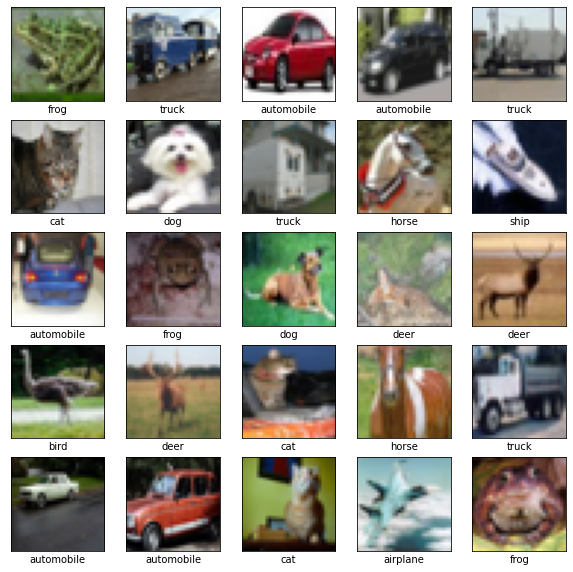

In [ ]:
data.showImages()

In [ ]:
 x_train,y_train,x_validation,y_validation,x_test,y_test = data.x_train,data.y_train,data.x_valid,data.y_valid,data.x_test,data.y_test

In [ ]:

def get_model(data):
    model = Sequential()

    # Convolutional Layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    # Pooling layer
    model.add(MaxPool2D(pool_size=(2, 2)))
    # Dropout layers
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    # model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
    return model

In [ ]:
def fitModel(model, data):
    early_stop = EarlyStopping(monitor='val_accuracy', patience=20)
    model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
    callbacks = [early_stop, model_checkpoint_cb]
    x_train,y_train,x_validation,y_validation,x_test,y_test = data.x_train,data.y_train,data.x_valid,data.y_valid,data.x_test,data.y_test
    batch_size = 32
    data_generator = ImageDataGenerator( horizontal_flip=True)
    train_generator = data_generator.flow(x_train, y_train, batch_size)
    steps_per_epoch = x_train.shape[0] // batch_size
    results = model.fit(train_generator, 
                epochs=50,
                steps_per_epoch=steps_per_epoch,
                validation_data=(x_validation, y_validation), 
                callbacks=callbacks,
                batch_size=batch_size,
              )
   
    return model


In [ ]:
runImageClassification(get_model, fitModel)

Preparing data...
Creating model...
Fitting model...
Epoch 1/50
1406/1406 [==============================] - 61s 22ms/step - loss: 1.5582 - accuracy: 0.4404 - precision: 0.6429 - recall: 0.2446 - val_loss: 1.3791 - val_accuracy: 0.5160 - val_precision: 0.6250 - val_recall: 0.4158
Epoch 2/50
1406/1406 [==============================] - 31s 22ms/step - loss: 1.1148 - accuracy: 0.6095 - precision: 0.7537 - recall: 0.4685 - val_loss: 1.0346 - val_accuracy: 0.6371 - val_precision: 0.7966 - val_recall: 0.4903
Epoch 3/50
1406/1406 [==============================] - 32s 23ms/step - loss: 0.9335 - accuracy: 0.6769 - precision: 0.7964 - recall: 0.5642 - val_loss: 0.8947 - val_accuracy: 0.6897 - val_precision: 0.8030 - val_recall: 0.5907
Epoch 4/50
1406/1406 [==============================] - 34s 24ms/step - loss: 0.8342 - accuracy: 0.7146 - precision: 0.8166 - recall: 0.6179 - val_loss: 0.7689 - val_accuracy: 0.7383 - val_precision: 0.8229 - val_recall: 0.6617
Epoch 5/50
1406/1406 [=============